In [ ]:
import tensorflow as tf
import os
import time
import datetime
import cv2
import sys
from PIL import Image
import glob as glob
from matplotlib import pyplot as plt
from IPython import display

In [ ]:
#data importing

_URL=r"/content/drive/MyDrive/Human-Segmentation-Dataset/"

sample_image=tf.io.read_file(_URL+'Temp/1.jpg')
sample_image=tf.io.decode_png(sample_image)
print(sample_image.shape)

(640, 960, 3)


In [ ]:
for ind,images in enumerate(glob.glob(_URL + 'Ground_Truth/*.png')):
  temp=images.split('/')[-1][:-4]
  print(temp)
  imgray=cv2.imread(images)
  cv2.imwrite(_URL + 'Temp/' + str(temp)+ '.jpg',imgray)

147
166
143
237
58
245
176
249
228
190
221
129
223
60
208
181
212
258
92
19
17
162
269
281
44
222
282
235
37
56
168
33
34
90
191
48
85
151
62
216
2
270
174
287
154
106
126
68
36
198
43
27
82
187
196
240
230
13
74
139
120
28
121
1
142
200
167
80
170
96
236
178
89
215
25
264
63
165
6
116
94
14
123
153
109
22
81
155
284
137
206
31
161
225
91
55
242
52
79
272
104
86
255
12
21
288
214
260
67
285
278
179
24
10
7
289
243
18
210
8
202
226
102
78
101
65
45
9
130
177
300
127
108
107
50
251
111
233
76
163
277
229
186
84
11
261
239
133
88
256
5
199
138
119
128
40
159
32
141
201
135
70
273
100
188
117
275
248
136
71
53
69
184
122
175
203
146
252
244
232
286
72
47
160
254
274
169
23
263
211
158
164
148
54
271
93
241
132
152
266
118
193
180
97
35
238
149
145
113
41
49
267
217
29
279
95
112
144
51
246
197
205
61
83
110
42
114
3
280
183
227
66
125
262
4
250
105
192
247
30
77
185
59
73
103
171
38
218
220
15
115
87
157
265
276
204
134
64
209
140
57
194
283
213
268
259
172
46
16
99
150
20
207
219
173
98
1

In [ ]:
sample_image=tf.io.read_file(_URL+'Training_Images/106.jpg')
sample_image=tf.io.decode_png(sample_image)
print(sample_image.shape)

(458, 307, 3)


In [ ]:
i=1
for images in glob.glob(_URL + 'Training_Images/*.jpg'):
  temp=images.split('/')[-1][0:-4]
  
  images = [Image.open(x) for x in [images,_URL+'Temp/' + str(temp) +'.jpg']]
  widths, heights = zip(*(i.size for i in images))
  total_width = sum(widths)
  if widths[0]<widths[1]:
    total_width-=(widths[1]-widths[0])
  else:
    total_width+=(widths[0]-widths[1])
  
  max_height = max(heights)

  new_im = Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  new_im.save(_URL + 'Final/' + str(i) + '.jpg')
  i+=1

In [ ]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2

  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

(480, 640, 3)


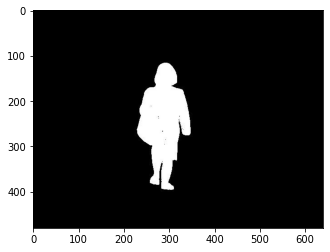

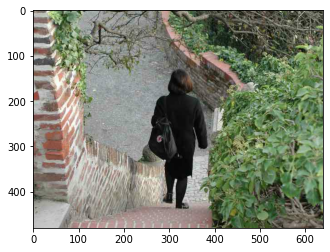

In [ ]:
inp, re= load(_URL + 'Final/102.jpg')
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)
print(re.shape)

In [ ]:
BUFFER_SIZE = 291
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256


In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, 256, 256, 3])

  return cropped_image[0], cropped_image[1]


In [ ]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image


In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return real_image, input_image


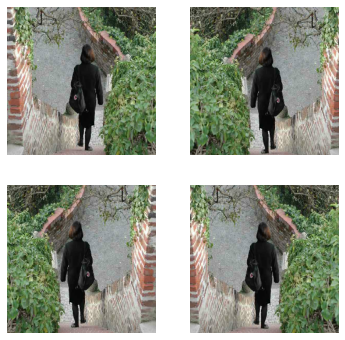

(256, 256, 3)


In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()
print(rj_inp.shape)

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(_URL+'Final/*.jpg')
print(train_dataset)
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)


<ShuffleDataset shapes: (), types: tf.string>


In [ ]:
OUTPUT_CHANNELS = 3


In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


In [ ]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)


NameError: ignored

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0.,0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)


NameError: ignored

In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


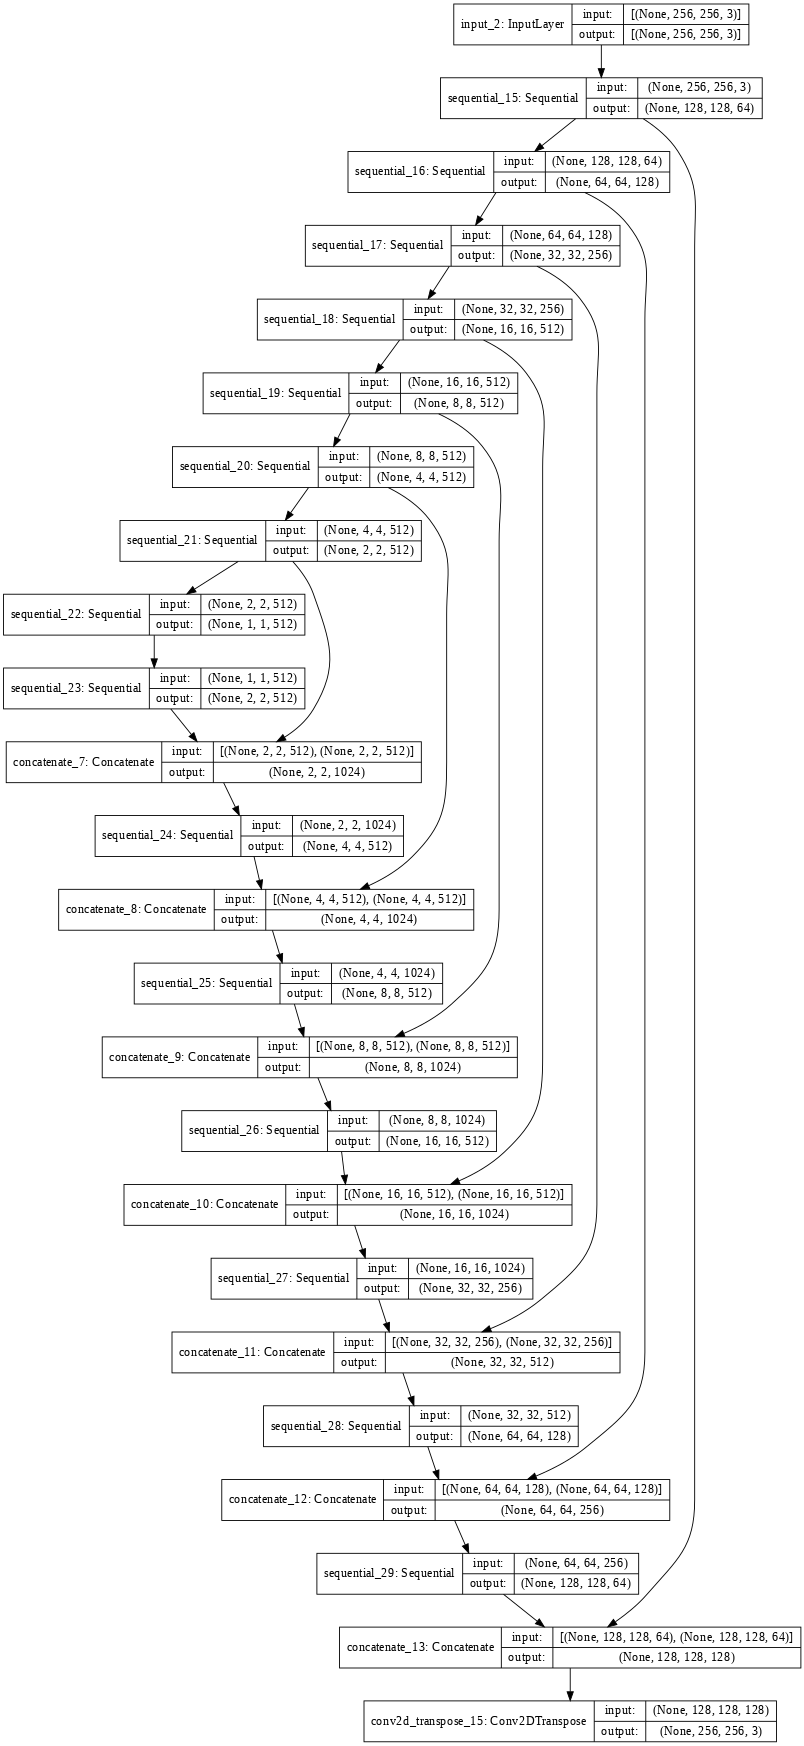

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)


In [ ]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])


ValueError: ignored

In [ ]:
LAMBDA = 100


In [ ]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss


In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


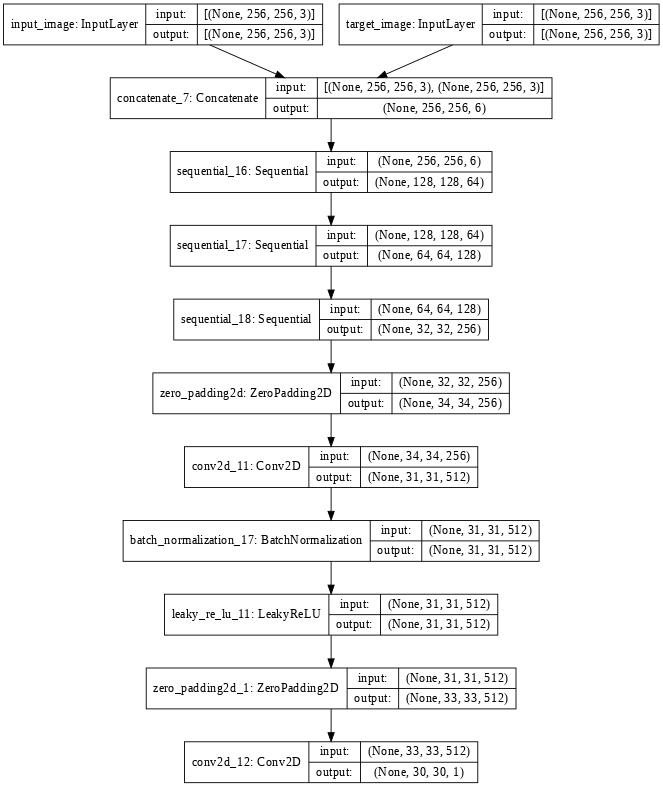

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)


In [ ]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()


NameError: ignored

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [ ]:
checkpoint_dir = _URL 
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()


In [ ]:
EPOCHS = 150
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


In [ ]:
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    boxes,scores=run_detector(detector,target)
    if(len(boxes)==0):
      return
    ymin, xmin, ymax, xmax = tuple(boxes[0])
    (left, right, top, bottom) = (int)(xmin * 256), (int)(xmax * 256),(int)(ymin * 256), (int)(ymax * 256)
    im=tf.image.crop_to_bounding_box(image=input_image,offset_height=top,offset_width=left,target_height=bottom-top,target_width=right-left)
    temp=np.zeros(input_image.shape)

    temp[0,top:bottom,left:right,0]=im[:,:,:,0]
    temp[0,top:bottom,left:right,1]=im[:,:,:,1]
    temp[0,top:bottom,left:right,2]=im[:,:,:,2]

    gen_output = generator(temp, training=True)

    disc_generated_output = discriminator([input_image, gen_output], training=True)
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=epoch)
    tf.summary.scalar('disc_loss', disc_loss, step=epoch)


In [ ]:
generator= tf.keras.models.load_model('/content/drive/MyDrive/Human-Segmentation-Dataset/Generator_Model/generator.h5')
discriminator=tf.keras.models.load_model('/content/drive/MyDrive/Human-Segmentation-Dataset/Discriminator_Model/discriminator.h5')

In [ ]:
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Training step
    i=1
    for n, (input_image, target) in train_ds.enumerate():
      print(i,end=' ')
      i+=1
      if (n+1) % 100 == 0:
        print()
      train_step(input_image, target, epoch)
    print()

    # Saving (checkpointing) the model every 20 epochs
    if (epoch + 1) % 10 == 0:
      generator.save('/content/drive/MyDrive/Human-Segmentation-Dataset/Generator_Model/generator.h5')
      discriminator.save('/content/drive/MyDrive/Human-Segmentation-Dataset/Discriminator_Model/discriminator.h5')
      checkpoint.save(file_prefix=checkpoint_prefix)
      %reload_ext tensorboard
      %tensorboard --logdir {log_dir}
    if epoch==0:   
      %load_ext tensorboard
      %tensorboard --logdir {log_dir}
      

    print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                        time.time()-start))
  checkpoint.save(file_prefix=checkpoint_prefix)


In [ ]:
import tensorflow_hub as hub
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

detector = hub.load(module_handle).signatures['default']


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img


2.5.0
The following GPU devices are available: /device:GPU:0


In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               thickness=4,):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())
  for i in range(min(len(boxes), max_boxes)):
    image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
    if scores[i] >= 0.4:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      color = colors[hash(class_names[i]) % len(colors)]
      
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,)
      np.copyto(image, np.array(image_pil))
  return image


In [ ]:
def run_detector(detector, img):
  #img = load_img(path)

  #converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(img)
  end_time = time.time()
  result = {key:value.numpy() for key,value in result.items()}
  
  boxes=[]
  scores=[]
  temp=result["detection_class_entities"]
  for i in range(len(temp)):
    if temp[i]==b'Person':
      boxes.append(result["detection_boxes"][i])
      scores.append(result["detection_scores"][i])
    elif temp[i]==b'Man':
      boxes.append(result["detection_boxes"][i]);
      scores.append(result["detection_scores"][i])
    elif temp[i]==b'Woman':
      boxes.append(result["detection_boxes"][i])
      scores.append(result["detection_scores"][i])
    elif temp[i]==b'Human body':
      boxes.append(result["detection_boxes"][i])
      scores.append(result["detection_scores"][i])
    elif temp[i]==b'Boy':
      boxes.append(result["detection_boxes"][i])
      scores.append(result["detection_scores"][i])

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  # image_with_boxes = draw_boxes(
  #     img.numpy(), boxes,
  #     entities, scores)

  # display_image(image_with_boxes)
  return (boxes,scores)


In [ ]:
imk=run_detector(detector,_URL + 'Final/1.jpg')

In [ ]:
for ind,images in enumerate(glob.glob(_URL + 'Final/*.jpg')):
  image=run_detector(detector,images)
  print(ind)
  cv2.imwrite(_URL + 'Temp/'+ str(ind) + '.jpg',cv2.cvtColor(image, cv2.COLOR_RGB2BGR))


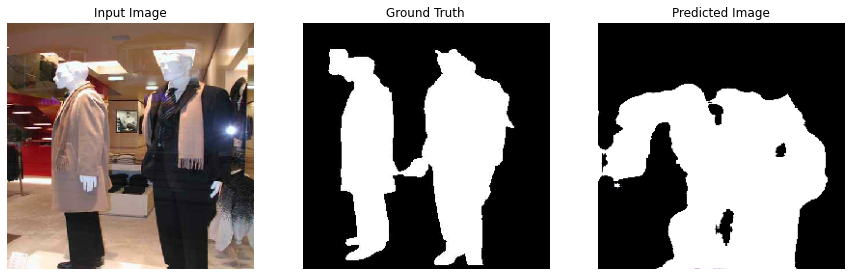

Epoch:  9
1 Found 100 objects.
Inference time:  1.1591873168945312
2 Found 100 objects.
Inference time:  1.0971333980560303
3 Found 100 objects.
Inference time:  1.0803015232086182
4 Found 100 objects.
Inference time:  1.085080862045288
5 Found 100 objects.
Inference time:  1.1127843856811523
6 Found 100 objects.
Inference time:  1.103853702545166
7 Found 100 objects.
Inference time:  1.09344482421875
8 Found 100 objects.
Inference time:  1.0961401462554932
9 Found 100 objects.
Inference time:  1.1028633117675781
10 Found 100 objects.
Inference time:  1.107123851776123
11 Found 100 objects.
Inference time:  1.122974157333374
12 Found 100 objects.
Inference time:  1.0961973667144775
13 Found 100 objects.
Inference time:  1.0897753238677979
14 Found 100 objects.
Inference time:  1.0878105163574219
15 Found 100 objects.
Inference time:  1.103564739227295
16 Found 100 objects.
Inference time:  1.1223008632659912
17 Found 100 objects.
Inference time:  1.1228382587432861
18 Found 100 objects

NameError: ignored

In [ ]:
fit(train_dataset, EPOCHS, train_dataset)

In [ ]:


test_ds = tf.data.Dataset.list_files(_URL+'Final/*.jpg')
test_ds = test_ds.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.shuffle(BUFFER_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [ ]:
generator.save('/content/drive/MyDrive/Human-Segmentation-Dataset/Generator_Model/generator.h5')
discriminator.save('/content/drive/MyDrive/Human-Segmentation-Dataset/Discriminator_Model/discriminator.h5')

Found 100 objects.
Inference time:  19.013556003570557
newModel- trimmed image


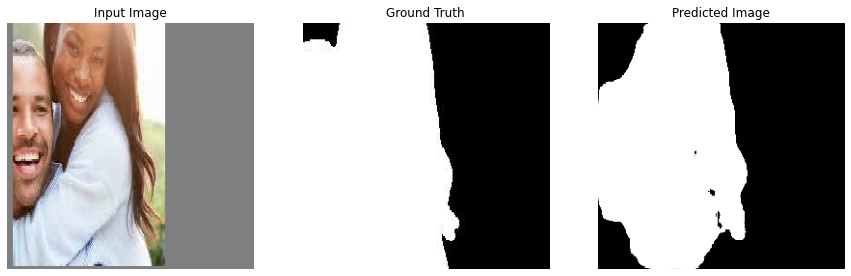

newModel- actual image


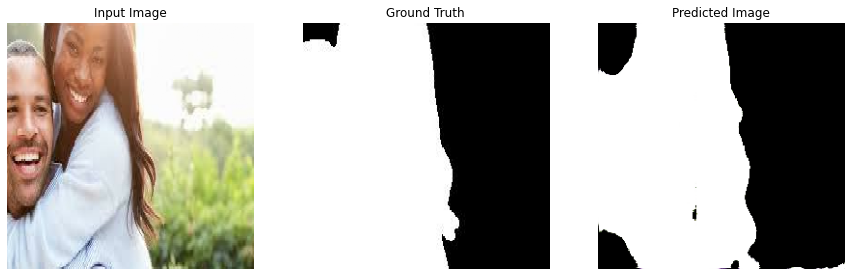

oldModel-trimmed image


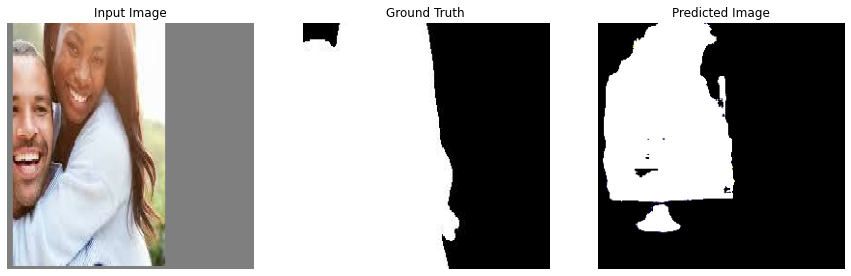

oldModel- actual image


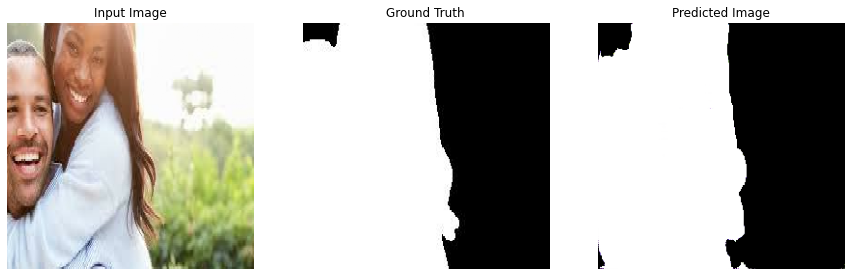

In [ ]:
for example_input, example_target in test_ds.take(1):
    boxes,scores=run_detector(detector,example_input)
    ymin, xmin, ymax, xmax = tuple(boxes[0])
    (left, right, top, bottom) = (int)(xmin * 256), (int)(xmax * 256),(int)(ymin * 256), (int)(ymax * 256)
    im=tf.image.crop_to_bounding_box(image=example_input,offset_height=top,offset_width=left,target_height=bottom-top,target_width=right-left)
    temp=np.zeros(example_input.shape)

    temp[0,top:bottom,left:right,0]=im[:,:,:,0]
    temp[0,top:bottom,left:right,1]=im[:,:,:,1]
    temp[0,top:bottom,left:right,2]=im[:,:,:,2]
    print('newModel- trimmed image')
    generate_images(generator, temp, example_target)
    print('newModel- actual image')
    generate_images(generator,example_input,example_target)
    print('oldModel-trimmed image')
    generate_images(generator2, temp, example_target)
    print('oldModel- actual image')
    generate_images(generator2,example_input,example_target)